# dataset:  'https://www.kaggle.com/datasets/trolukovich/food11-image-dataset'

In [9]:
# import the necessary libraries & Modules
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler 
from random import sample


In [ ]:
train = {}
test = {}

path = "/content/drive/MyDrive/archive"

# here i Create a dictionary that stores pictures for each category in the train data.
path_train = os.path.join(path, "training")
for i in os.listdir(path_train):
    train[i] = os.listdir(os.path.join(path_train, i))

# here i Create a dictionary that stores pictures for each category under test data.
path_test = os.path.join(path, "validation")
for i in os.listdir(path_test):
    test[i] = os.listdir(os.path.join(path_test, i))

In [10]:
train_path=r'C:\tmp\testdata\training'
test_path=r'C:\tmp\testdata\validation'
for d in [train_path, test_path]:
    filepaths = []
    labels=[] 
    classlist=os.listdir(d)   
    for klass in classlist:
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)        
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    else:
        df=pdf
train_df, valid_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])    
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))



train_df lenght:  8879   test_df length:  3430   valid_df length:  987
The number of classes in the dataset is:  11
            CLASS               IMAGE COUNT 
            Bread                   895     
        Dairy product               386     
           Dessert                 1350     
             Egg                    887     
          Fried food                763     
             Meat                  1192     
        Noodles-Pasta               396     
             Rice                   252     
           Seafood                  770     
             Soup                  1350     
       Vegetable-Fruit              638     


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# here i View the number of images in the entire training and testing datasets.
len_train = np.concatenate(list(train.values())).shape[0]
len_test = np.concatenate(list(test.values())).shape[0]

print("Number of images in training data : {}".format(len_train))
print("Number of images in testing data : {}".format(len_test))

Number of images in training data : 9866
Number of images in testing data : 3430


In [ ]:
# here i View the number of images in each of the 6 categories in the training data.
for item in train.keys():
    print(item, len(train[item]))

Fried food 848
Egg 986
Soup 1500
Seafood 855
Vegetable-Fruit 709
Meat 1325
Dessert 1500
Rice 280
Noodles-Pasta 440
Dairy product 429
Bread 994


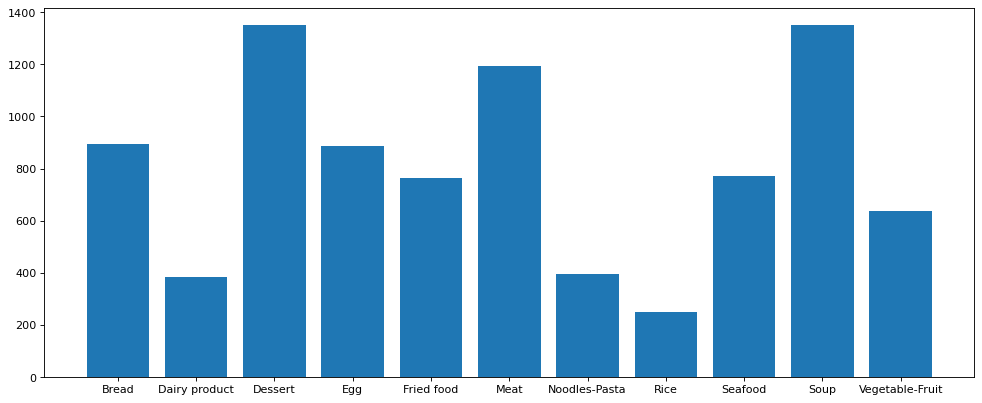

In [12]:

from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=80)

x = np.array(classlist)
y = np.array(countlist)

plt.bar(x,y)
plt.show()

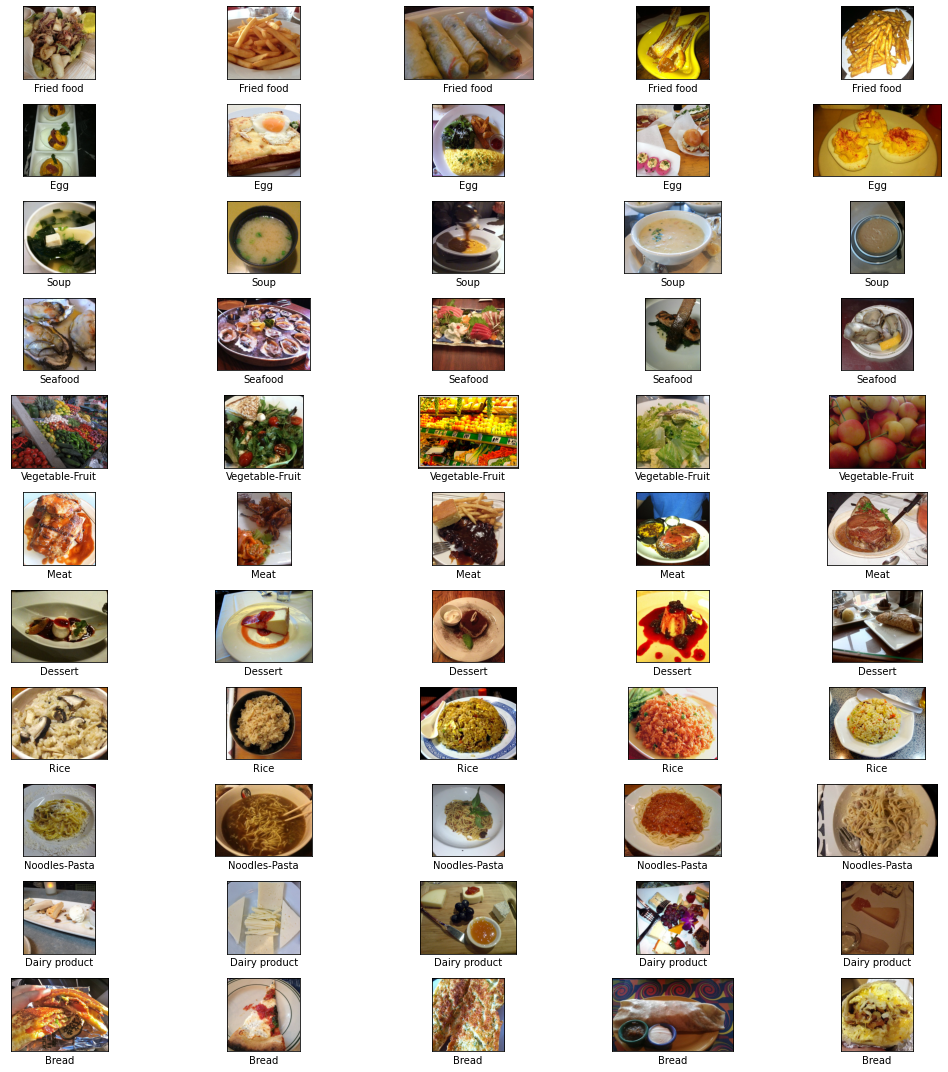

In [ ]:
# here Randomly display 5 images each of the 11 classes from the training data
fig, axs = plt.subplots(len(train.keys()), 5, figsize = (15, 15))
for i, item in enumerate(os.listdir(path_train)):
    images = sample(train[item], 5)
    
    for j, image in enumerate(images):
        img = PIL.Image.open(os.path.join(path_train, item, image))
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = item, xticks = [], yticks = [])

fig.tight_layout()

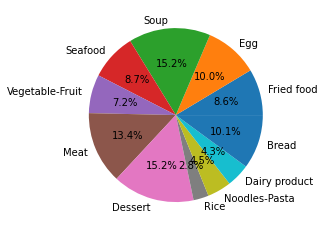

In [ ]:
# here i Make a pie-chart to visualize the percentage contribution of each CLASS.
fig, ax = plt.subplots()
ax.pie(
    [len(train[item]) for item in train],
    labels = train.keys(),
    autopct = "%1.1f%%"
)
fig.show()

In [40]:
# this pretrined model
# i Create an Image Generator  
# i specify the type of data augmentation.
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rescale=1./255
)

#  test data we 
test_datagen = ImageDataGenerator(rescale=1./255)

In [39]:
# here Create a generator for the images. 

# Train generator
train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


In [41]:
# Load the inception resnetv2 model
basemodel = InceptionResNetV2(
    weights = "imagenet",
    include_top = False, # Classification layer (output layer- sigmoid activations)
    input_tensor = Input((256, 256, 3))
)

In [42]:
# print the model summary
basemodel.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_207 (Conv2D)            (None, 127, 127, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 127, 127, 32  96         ['conv2d_207[0][0]']             
 Normalization)                 )                                               

In [48]:
basemodel.trainable = False

In [49]:
# here i Add classification head to the model
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D(name = "Global_Average_Pool")(headmodel)
headmodel = Flatten(name = "flatten")(headmodel)
headmodel = Dense(256, activation = "relu", name = "dense_1")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu", name = "dense_2")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(11, activation = "softmax", name = "output")(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [50]:
# i Compile the model
model.compile(
    loss = "categorical_crossentropy",
    optimizer = SGD(
        lr = 0.01,
        momentum = 0.9
    ),
    metrics = ["accuracy"]
)

In [51]:
# Using early stopping 
earlystopping = EarlyStopping(
    monitor = 'loss', 
    verbose = 1, 
    patience = 20
)

# saving the best model with lower loss
checkpointer = ModelCheckpoint(
    filepath = "pretrined_Model.hdf5", 
    verbose = 1, 
    save_best_only = True
)

In [53]:
# traijn the model
history = model.fit(
    train_generator, 
    steps_per_epoch = train_generator.n // 32, 
    epochs = 2, 
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/2
308/308 [==============================] - ETA: 0s - loss: 0.6995 - accuracy: 0.7782

308/308 [==============================] - 73s 235ms/step - loss: 0.6995 - accuracy: 0.7782
Epoch 2/2
308/308 [==============================] - ETA: 0s - loss: 0.6184 - accuracy: 0.8006

308/308 [==============================] - 72s 233ms/step - loss: 0.6184 - accuracy: 0.8006


In [54]:
basemodel.trainable = True

In [55]:
# Using early stopping 
earlystopping = EarlyStopping(
    monitor = 'loss', 
    verbose = 1, 
    patience = 20
)

# Saving the best model with lower loss
checkpointer = ModelCheckpoint(
    filepath = "pretrined_Model.hdf5", 
    verbose = 1, 
    save_best_only = True
)

In [63]:
# training
history = model.fit(
    train_generator, 
    steps_per_epoch = train_generator.n // 32, 
    epochs = 12, 
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/12
308/308 [==============================] - ETA: 0s - loss: 0.3340 - accuracy: 0.8913

308/308 [==============================] - 73s 235ms/step - loss: 0.3340 - accuracy: 0.8913
Epoch 2/12
308/308 [==============================] - ETA: 0s - loss: 0.3303 - accuracy: 0.8921

308/308 [==============================] - 72s 233ms/step - loss: 0.3303 - accuracy: 0.8921
Epoch 3/12
308/308 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.8932

308/308 [==============================] - 72s 234ms/step - loss: 0.3199 - accuracy: 0.8932
Epoch 4/12
308/308 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8965

308/308 [==============================] - 72s 233ms/step - loss: 0.3067 - accuracy: 0.8965
Epoch 5/12
308/308 [==============================] - ETA: 0s - loss: 0.2992 - accuracy: 0.8972

308/308 [==============================] - 72s 233ms/step - loss: 0.2992 - accuracy: 0.8972
Epoch 6/12
308/308 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.8994

308/308 [==============================] - 72s 235ms/step - loss: 0.2973 - accuracy: 0.8994
Epoch 7/12
308/308 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.8986

308/308 [==============================] - 72s 233ms/step - loss: 0.2921 - accuracy: 0.8986
Epoch 8/12
308/308 [==============================] - ETA: 0s - loss: 0.2803 - accuracy: 0.9053

308/308 [==============================] - 72s 233ms/step - loss: 0.2803 - accuracy: 0.9053
Epoch 9/12
308/308 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.9100

308/308 [==============================] - 72s 233ms/step - loss: 0.2637 - accuracy: 0.9100
Epoch 10/12
308/308 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.9136

308/308 [==============================] - 72s 233ms/step - loss: 0.2533 - accuracy: 0.9136
Epoch 11/12
308/308 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.9132

308/308 [==============================] - 72s 234ms/step - loss: 0.2556 - accuracy: 0.9132
Epoch 12/12
308/308 [==============================] - ETA: 0s - loss: 0.2504 - accuracy: 0.9140

308/308 [==============================] - 72s 234ms/step - loss: 0.2504 - accuracy: 0.9140


In [ ]:
# this is the custom model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import SGD
# Set the directory paths for the training and validation data
train_dir = '/content/drive/MyDrive/archive/training'
validation_dir = '/content/drive/MyDrive/archive/validation'

# i Used the ImageDataGenerator 
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# Model architecture
input_shape = (224, 224, 3)
input_tensor = Input(shape=input_shape)

#Custom architecture
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_tensor)
x = MaxPooling2D()(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)

# i Add classification head
x = Dense(256, activation = "relu", name = "dense_1")(x)
x = Dropout(0.3)(x)
x = Dense(128, activation = "relu", name = "dense_2")(x)
x = Dropout(0.3)(x)
output = Dense(11, activation = "softmax", name = "output")(x)

model = Model(inputs = input_tensor, outputs = output)

# Compile the model with a loss function, optimizer, and metrics
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

earlystopping = EarlyStopping(
    monitor = 'loss', 
    verbose = 1, 
    patience = 20
)

# Saving the 
checkpointer = ModelCheckpoint(
    filepath = "custom_Model.hdf5", 
    verbose = 1, 
    save_best_only = True
)

# Training the model 
model.fit_generator(
    train_generator,
    steps_per_epoch=308,
    epochs=10,
    validation_data=val_generator,
    validation_steps=154,
        callbacks = [checkpointer, earlystopping]

    )




In [83]:
# summary of custom model
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_207 (Conv2D)            (None, 127, 127, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 127, 127, 32  96         ['conv2d_207[0][0]']             
 Normalization)                 )                                                           

In [64]:
# Evaluate the performance of the model
evaluate = model.evaluate_generator(
    test_generator, 
    steps = test_generator.n // 32, 
    verbose = 1
)

print('Accuracy Test : {}'.format(evaluate[1]))

<ipython-input-64-ac9dd2bc844d>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(


107/107 [==============================] - 27s 250ms/step - loss: 0.4888 - accuracy: 0.8683
Accuracy Test : 0.8682827353477478


In [65]:
# Assigning label names to the corresponding indexes
labels = {
    0: 'Bread', 
    1: 'Dairy product', 
    2: 'Dessert', 
    3: 'Egg', 
    4: 'Fried food', 
    5: 'Meat',
    6: 'Noodles-Pasta',
    7: 'Rice', 
    8: 'Seafood',
    9: 'Soup',
    10: 'Vegetable-Fruit'
}

In [66]:
# Loading images and their predictions 
prediction = []
original = []
image = []
count = 0
path_eval = "/content/drive/MyDrive/archive/evaluation"
for i in os.listdir(path_eval):
    for item in os.listdir(os.path.join(path_eval, i)):
        img= PIL.Image.open(os.path.join(path_eval, i, item))
        img = img.resize((256,256))
        image.append(img)
        img = np.asarray(img, dtype= np.float32)
        img = img / 255
        img = img.reshape(-1,256,256,3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(labels[predict])
        original.append(i)

1/1 [==============================] - 0s 36ms/step


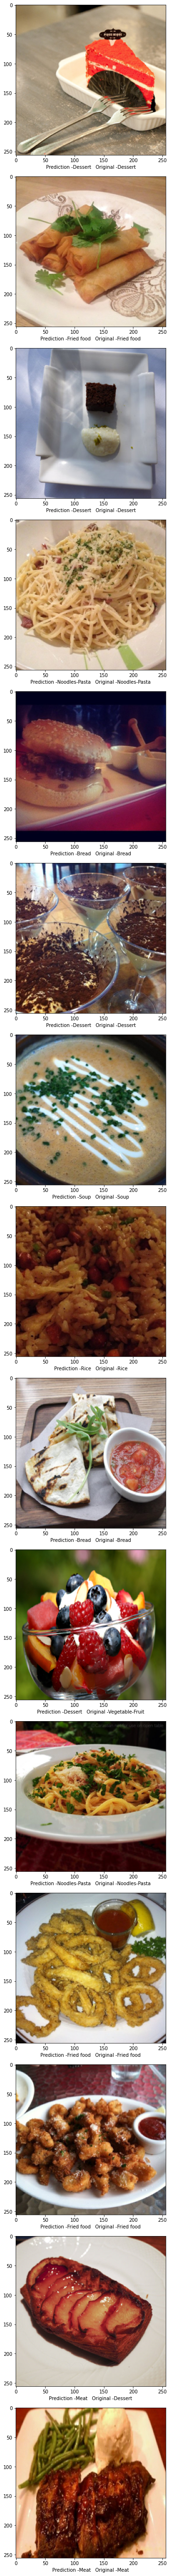

In [67]:
# Visualizing the results

indices = random.sample(range(len(image)), 15)
fig=plt.figure(figsize = (100,100))
for i, j in enumerate(indices):
    fig.add_subplot(20,1,i+1)
    plt.xlabel("Prediction -" + prediction[j] +"   Original -" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show() 


In [82]:
# print Classification Report 
print(classification_report(np.asarray(prediction), np.asarray(original)))



                 precision    recall  f1-score   support

          Bread       0.88      0.82      0.85       394
  Dairy product       0.72      0.81      0.76       132
        Dessert       0.81      0.86      0.83       468
            Egg       0.79      0.86      0.82       307
     Fried food       0.90      0.79      0.84       325
           Meat       0.87      0.88      0.87       424
  Noodles-Pasta       0.99      0.97      0.98       150
           Rice       0.99      0.90      0.94       106
        Seafood       0.90      0.89      0.90       306
           Soup       0.97      0.97      0.97       500
Vegetable-Fruit       0.95      0.93      0.94       235

       accuracy                           0.88      3347
      macro avg       0.89      0.88      0.88      3347
   weighted avg       0.88      0.88      0.88      3347



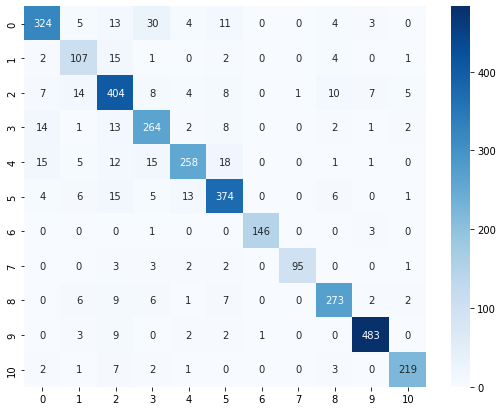

In [81]:
# showing the confusion matrix
plt.figure(figsize = (9, 7))
cm = confusion_matrix(np.asarray(prediction), np.asarray(original))
sns.heatmap(
    cm, 
    annot = True, 
    fmt = "d",
    cmap="Blues"
)
plt.show()

